In [1]:
import sys
import time
import torch
from pathlib import Path
import matplotlib.pyplot as plt
import os

print(os.getcwd())
os.chdir('..')
print(os.getcwd())

/home/david/miniforge3/envs/monorec/lib/python3.6/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


/home/david/deepdriving
/home/david


In [2]:
# coming from the MonoRec directory
home = str(Path.home())
sys.path.append(os.path.join(home, "deepdriving/MonoRec"))
from data_loader.kitti_odometry_dataset import KittiOdometryDataset
from model.monorec.monorec_model import MonoRecModel
from utils import unsqueezer, map_fn, to

Initializing model...
Fetching data...
Starting inference...


/home/david/miniforge3/envs/monorec/lib/python3.6/site-packages/torch/nn/functional.py:3226: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "
/home/david/miniforge3/envs/monorec/lib/python3.6/site-packages/torch/nn/functional.py:1558: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Inference took 0.7283399105072021s


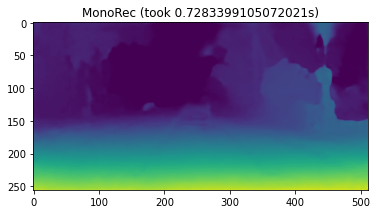

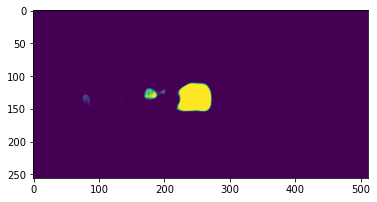

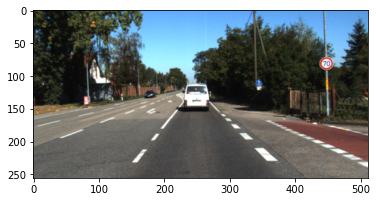

IT WORKS!


In [3]:
target_image_size = (256, 512)

device = "cuda:0" if torch.cuda.is_available() else "cpu"

kitti_path = os.path.join(home, "KITTI/dataset")

dataset = KittiOdometryDataset(kitti_path, 
                               frame_count=2,
                               sequences=["04"], 
                               depth_folder="image_depth_annotated", 
                               target_image_size=target_image_size, 
                               max_length=None,
                               offset_d=0,
                               use_color=True,
                               use_dso_poses=False,
                               lidar_depth=True, 
                               dso_depth=False,
                               annotated_lidar=True,
                               return_stereo=False,
                               return_mvobj_mask=False,
                               use_index_mask=())

checkpoint_location = os.path.join(home, "deepdriving/MonoRec/saved/checkpoints/monorec_depth_ref.pth")
inv_depth_min_max = [0.33, 0.0025]
print("Initializing model...")
monorec_model = MonoRecModel(checkpoint_location=checkpoint_location, 
                             inv_depth_min_max=inv_depth_min_max)

monorec_model.to(device)
monorec_model.eval()

print("Fetching data...")
index = 0

batch, depth = dataset.__getitem__(index)
batch = map_fn(batch, unsqueezer)
depth = map_fn(depth, unsqueezer)

batch = to(batch, device)

print("Starting inference...")
s = time.time()
with torch.no_grad():
    data = monorec_model(batch)

prediction = data["result"][0, 0].cpu()
mask = data["cv_mask"][0, 0].cpu()
depth = depth[0, 0].cpu()

e = time.time()
print(f"Inference took {e - s}s")

plt.imsave("depth.png", prediction.detach().squeeze())
plt.imsave("mask.png", mask.detach().squeeze())
plt.imsave("kf.png", batch["keyframe"][0].permute(1, 2, 0).cpu().numpy() + 0.5)

plt.title(f"MonoRec (took {e - s}s)")
plt.imshow(prediction.detach().squeeze(), vmin=1 / 80, vmax=1 / 5)
plt.show()
plt.imshow(mask.detach().squeeze())
plt.show()
plt.imshow(batch["keyframe"][0].permute(1, 2, 0).cpu() + .5)
plt.show()

print('IT WORKS!')